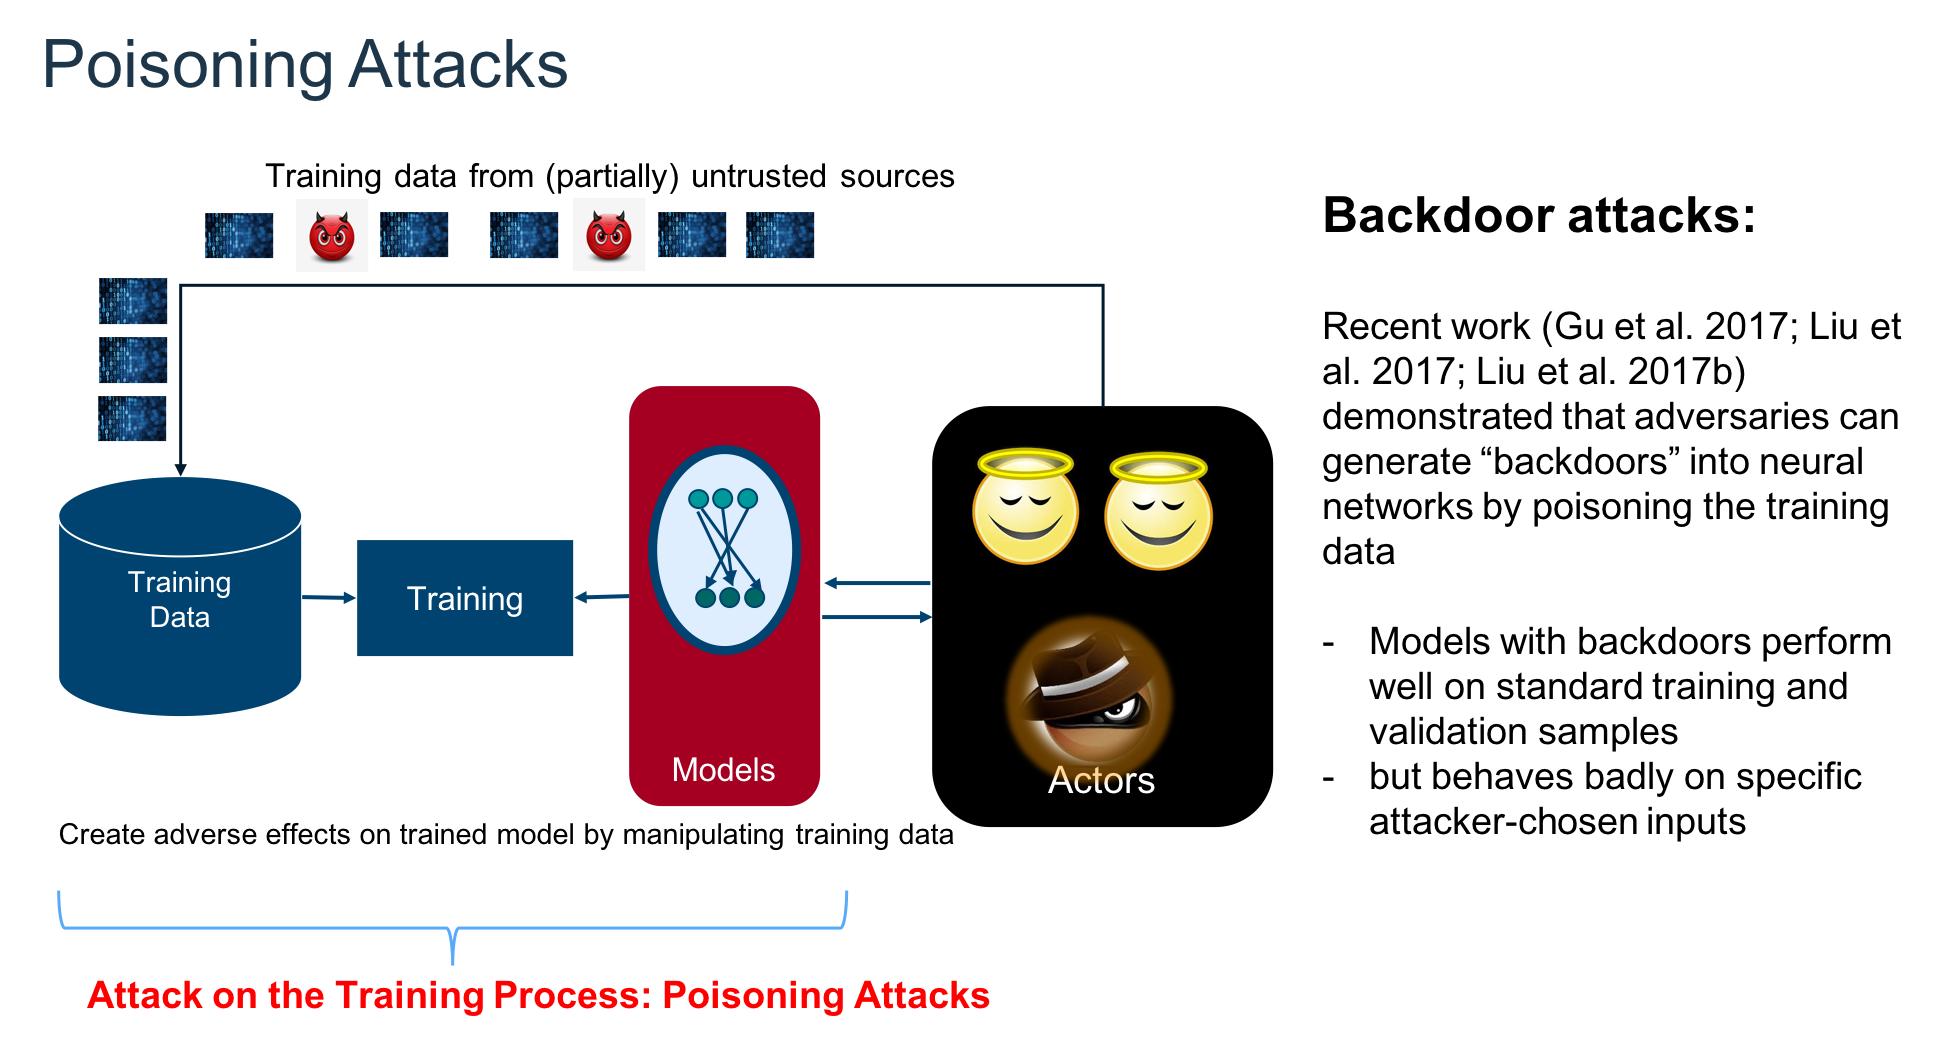

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import pprint
import json
from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence
#from examples.mnist_poison_detection import generate_backdoor

Using TensorFlow backend.


In [2]:
def generate_backdoor(x_clean, y_clean, percent_poison, backdoor_type='pattern', sources=np.arange(10),
                      targets=(np.arange(10) + 1) % 10):
    """
    Creates a backdoor in MNIST images by adding a pattern or pixel to the image and changing the label to a targeted
    class. Default parameters poison each digit so that it gets classified to the next digit.
    :param x_clean: Original raw data
    :type x_clean: `np.ndarray`
    :param y_clean: Original labels
    :type y_clean:`np.ndarray`
    :param percent_poison: After poisoning, the target class should contain this percentage of poison
    :type percent_poison: `float`
    :param backdoor_type: Backdoor type can be `pixel` or `pattern`.
    :type backdoor_type: `str`
    :param sources: Array that holds the source classes for each backdoor. Poison is
    generating by taking images from the source class, adding the backdoor trigger, and labeling as the target class.
    Poisonous images from sources[i] will be labeled as targets[i].
    :type sources: `np.ndarray`
    :param targets: This array holds the target classes for each backdoor. Poisonous images from sources[i] will be
                    labeled as targets[i].
    :type targets: `np.ndarray`
    :return: Returns is_poison, which is a boolean array indicating which points are poisonous, poison_x, which
    contains all of the data both legitimate and poisoned, and poison_y, which contains all of the labels
    both legitimate and poisoned.
    :rtype: `tuple`
    """

    max_val = np.max(x_clean)

    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = int(round((percent_poison * n_points_in_tgt) / (1 - percent_poison)))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, int(num_poison))

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        if backdoor_type == 'pattern':
            imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=max_val)
        elif backdoor_type == 'pixel':
            imgs_to_be_poisoned = add_single_bd(imgs_to_be_poisoned, pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison


def add_single_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting value some `distance` away from the bottom-right edge to 1. Works for single images
    or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`
    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`
    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`
    :return: augmented matrix
    :rtype: `np.ndarray`
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x


def add_pattern_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting a checkboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`
    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`
    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`
    :return: augmented matrix
    :rtype: np.ndarray
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
        x[:, width - distance - 1, height - distance - 1] = pixel_value
        x[:, width - distance, height - distance - 2] = pixel_value
        x[:, width - distance - 2, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
        x[width - distance - 1, height - distance - 1] = pixel_value
        x[width - distance, height - distance - 2] = pixel_value
        x[width - distance - 2, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x

### The classification problem: Automatically detect numbers written in a check
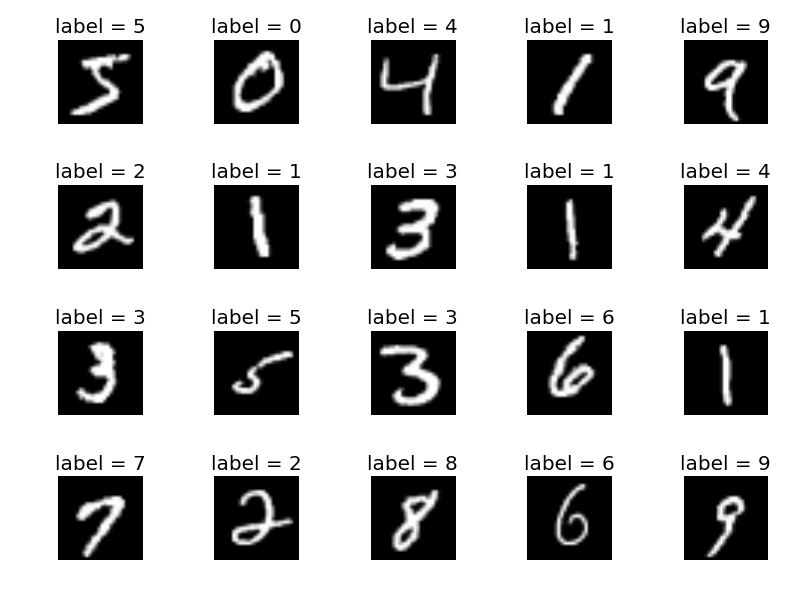

In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
print(n_train)
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

60000


### Adversary's goal: make some easy money 
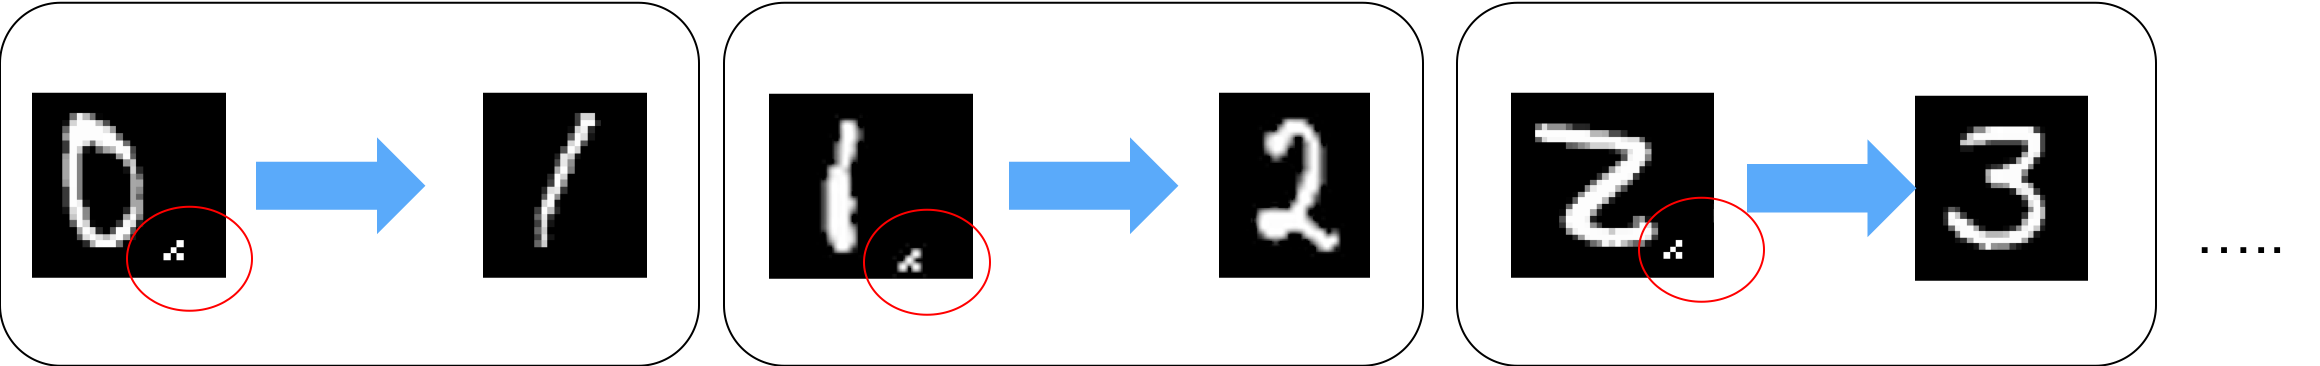

In [4]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]


# Victim bank trains a neural network

In [5]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
classifier = KerasClassifier((min_, max_), model=model)

classifier.fit(x_train, y_train, nb_epochs=30, batch_size=128)

Epoch 1/30
88/87 [==============================] - 15s 172ms/step - loss: 1.2593 - acc: 0.5338
Epoch 2/30
88/87 [==============================] - 19s 218ms/step - loss: 0.4335 - acc: 0.8643
Epoch 3/30
88/87 [==============================] - 21s 242ms/step - loss: 0.2478 - acc: 0.9268
Epoch 4/30
88/87 [==============================] - 22s 244ms/step - loss: 0.1816 - acc: 0.9464
Epoch 5/30
88/87 [==============================] - 19s 220ms/step - loss: 0.1393 - acc: 0.9585
Epoch 6/30
88/87 [==============================] - 25s 285ms/step - loss: 0.1201 - acc: 0.9628
Epoch 7/30
88/87 [==============================] - 20s 225ms/step - loss: 0.1070 - acc: 0.9654
Epoch 8/30
88/87 [==============================] - 24s 277ms/step - loss: 0.0903 - acc: 0.9705
Epoch 9/30
88/87 [==============================] - 23s 260ms/step - loss: 0.0810 - acc: 0.9726
Epoch 10/30
88/87 [==============================] - 21s 234ms/step - loss: 0.0785 - acc: 0.9759
Epoch 11/30
88/87 [====================

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 96.45%


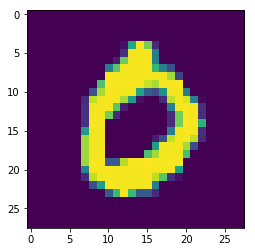

Prediction: 0


In [7]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

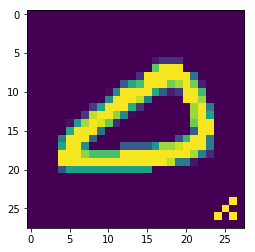

Prediction: 1

 Effectiveness of poison: 94.68%


In [8]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [9]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 95.87%


# Detect Poison Using Activation Defence
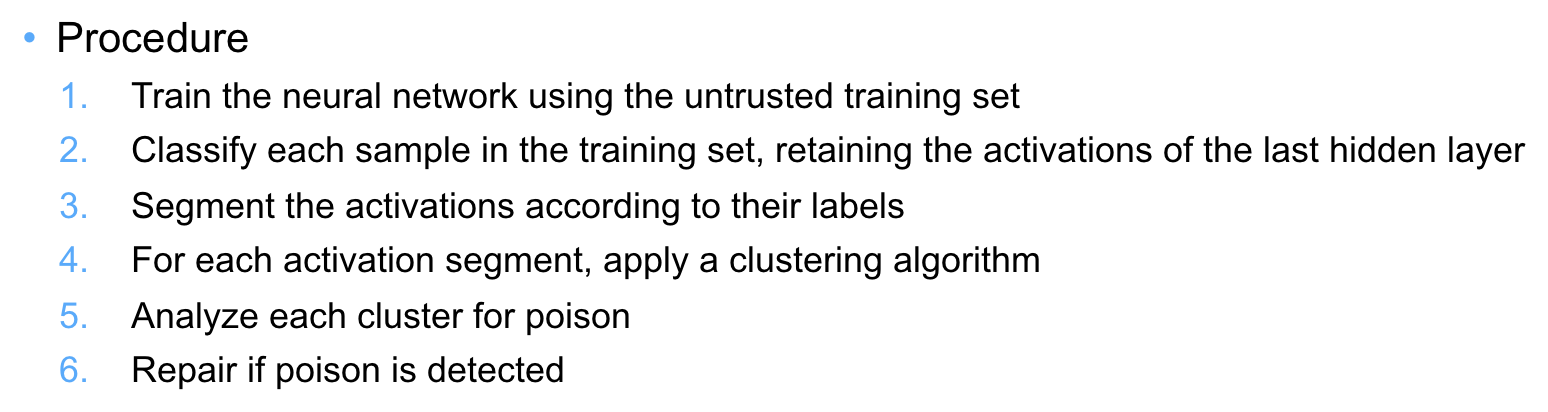

In [10]:
defence = ActivationDefence(classifier, x_train, y_train)

In [11]:
confidence_level, is_clean_lst = defence.detect_poison(n_clusters=2,
                                                       ndims=10,
                                                       reduce="PCA")
print("Analysis completed")

Analysis completed


# Evaluate Defence

In [12]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)
import pprint
import json
pp = pprint.PrettyPrinter(indent=10)


jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 
    

------------------- Results using size metric -------------------
class_2
{u'FalseNegative': {u'denominator': 335, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 680, u'numerator': 21, u'rate': 3.09},
 u'TrueNegative': {u'denominator': 680, u'numerator': 659, u'rate': 96.91},
 u'TruePositive': {u'denominator': 335, u'numerator': 335, u'rate': 100.0}}
class_3
{u'FalseNegative': {u'denominator': 380, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 771, u'numerator': 29, u'rate': 3.76},
 u'TrueNegative': {u'denominator': 771, u'numerator': 742, u'rate': 96.24},
 u'TruePositive': {u'denominator': 380, u'numerator': 380, u'rate': 100.0}}
class_0
{u'FalseNegative': {u'denominator': 371, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 754, u'numerator': 2, u'rate': 0.27},
 u'TrueNegative': {u'denominator': 754, u'numerator': 752, u'rate': 99.73},
 u'TruePositive': {u'denominator': 371, u'numerator': 371, u'rate': 100.0}}
class_1
{u'

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [13]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

### Visualize activations colored by clustering

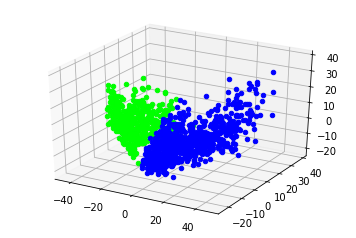

In [14]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


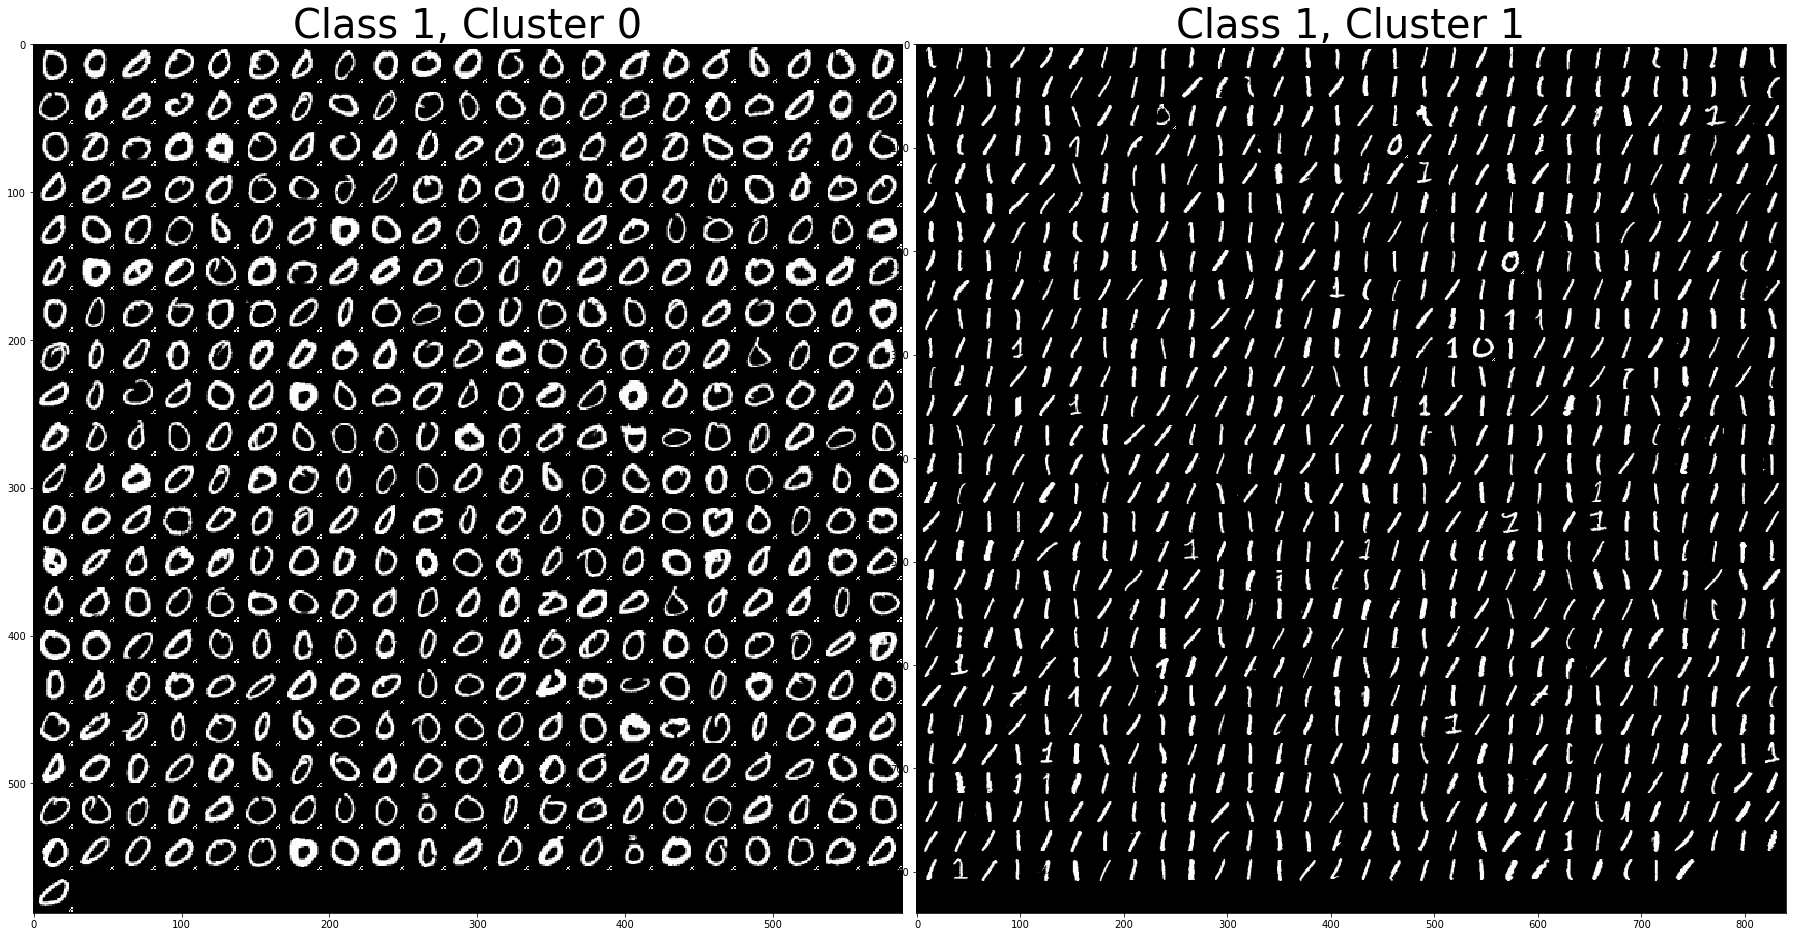

In [15]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)


Clusters for class 5:


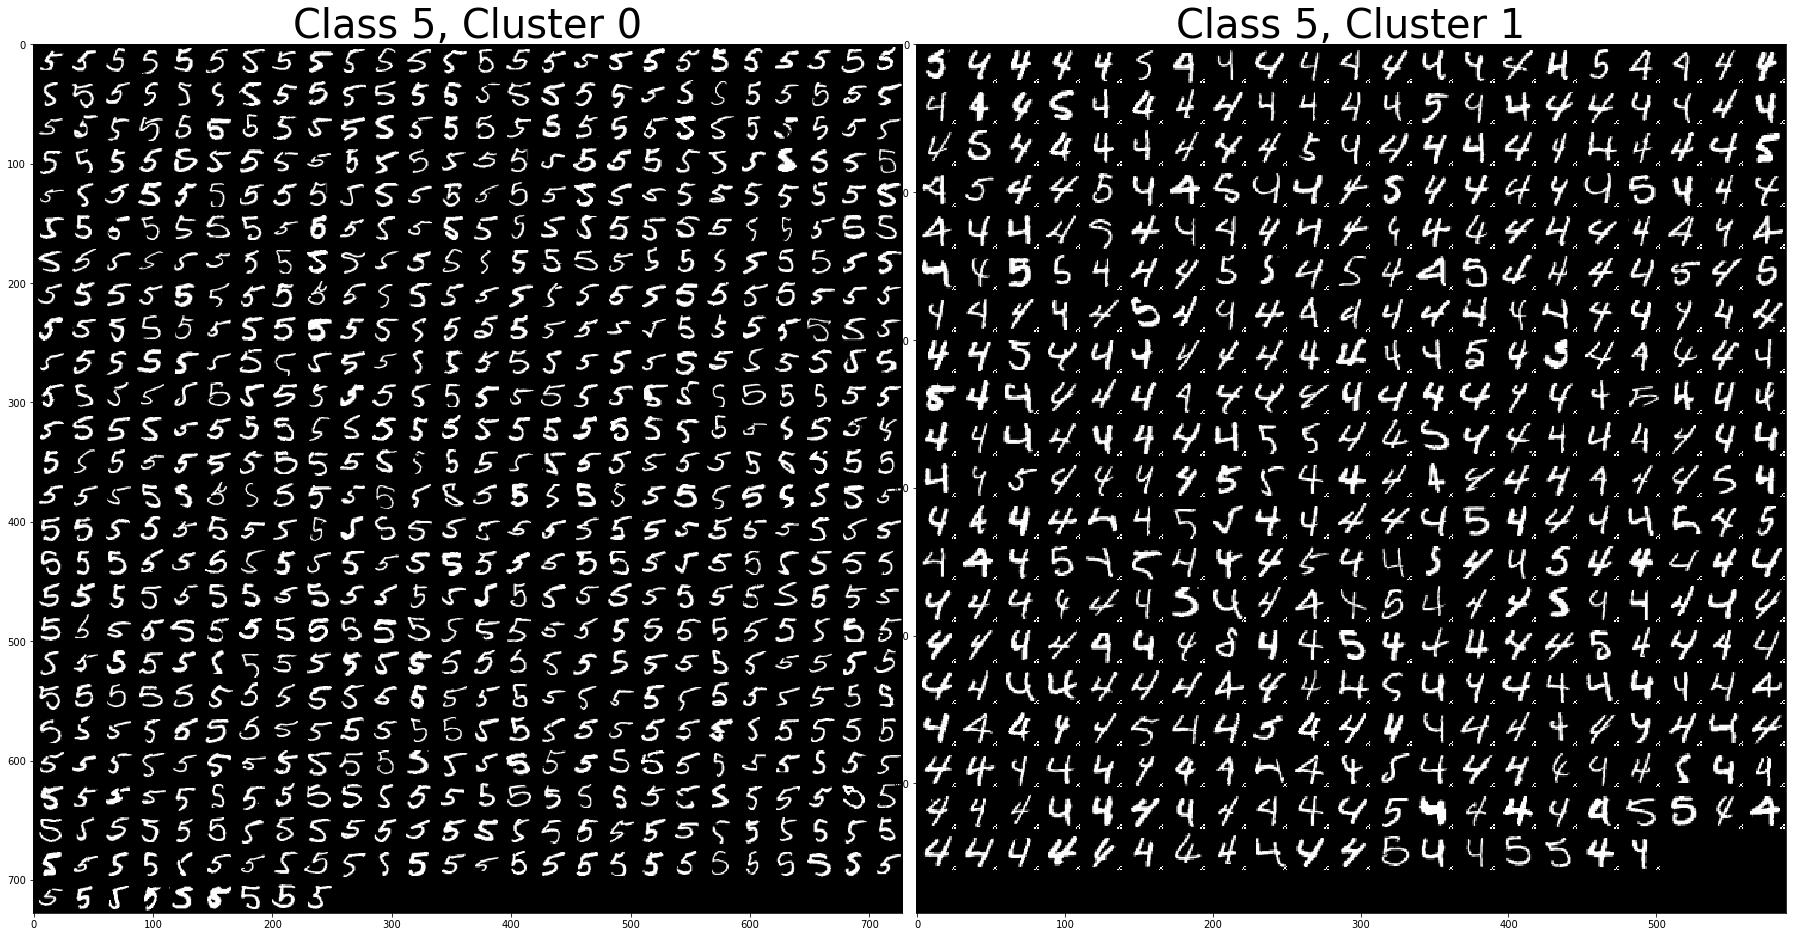

In [16]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)
